In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from BW import *
import sys
sys.setrecursionlimit(1000000)
from IPython.display import Image
import numpy as np
from HMMCRN import *
import crnsimulator

In [2]:
gen_model = hmm.CategoricalHMM(n_components=2, random_state=2)

gen_model.startprob_ = np.array([1, 0])

gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.25, 0.75]])

gen_model.emissionprob_ = \
    np.array([[1 / 3, 1 / 3, 1 / 3],
              [0.01, 0.01, 0.98]])

rolls, gen_states = gen_model.sample(300)

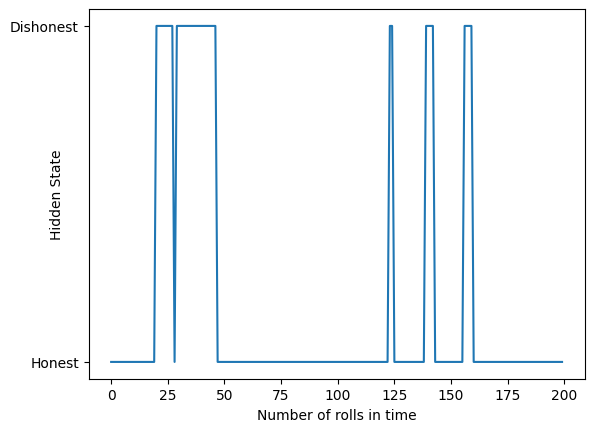

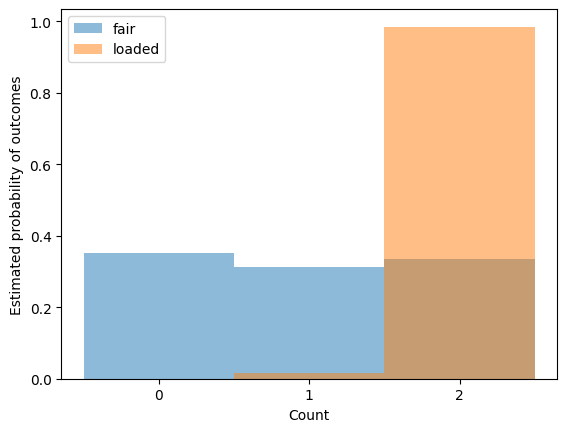

In [59]:
fig, ax = plt.subplots()
ax.plot(gen_states[:200])
#ax.set_title('Hidden State over time')
ax.set_xlabel('Number of rolls in time')
ax.set_ylabel('Hidden State')
plt.yticks([0,1], ["Honest","Dishonest"])
plt.gca().get_yaxis().set_label_coords(-0.05, 0.5)
plt.show()


# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(4) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(4) - 0.5, density=True)
#ax.set_title('Frequency of Roll Outcomes')
ax.set_xlabel('Count')
ax.set_ylabel('Estimated probability of outcomes')
plt.xticks([0,1,2])
ax.legend()
plt.savefig('PLOTS/dieprobs.pdf', format='pdf', dpi=300)
plt.show()

In [21]:
from sklearn.utils.validation import check_random_state
def normalize(a, axis=None):
    a_sum = a.sum(axis)
    if axis and a.ndim > 1:
        # Make sure we don't divide by zero.
        a_sum[a_sum == 0] = 1
        shape = list(a.shape)
        shape[axis] = 1
        a_sum.shape = shape

    a /= a_sum
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

gen_score = gen_model.score(X_validate)
np.random.seed(14)

model = hmm.CategoricalHMM(
    n_components=2, random_state=19,
    init_params='') 
model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                            np.random.dirichlet([0.1, 0.9])])
random_state = check_random_state(model.random_state)
model.startprob_=np.array([0.6,0.4])
model.emissionprob_ =random_state.rand(
            model.n_components, 3)
normalize(model.emissionprob_, axis=1)
bT0=model.startprob_
bTT=model.transmat_
bT1=model.emissionprob_
model.fit(X_train)
score = model.score(X_validate)

print(f'Generated score: {gen_score}\nBest score:      {score}')
print(bT0.round(3))
print(bTT.round(3))
print(bT1.round(3))
print(model.startprob_.round(3))
print(model.transmat_.round(3))
print(model.emissionprob_.round(3))


# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = model.predict(rolls)

Generated score: -149.2813734001072
Best score:      -147.9004629826131
[0.6 0.4]
[[1.    0.   ]
 [0.002 0.998]]
[[0.088 0.688 0.223]
 [0.25  0.6   0.15 ]]
[0. 1.]
[[0.902 0.098]
 [0.036 0.964]]
[[0.029 0.067 0.904]
 [0.369 0.355 0.276]]


In [22]:
model.monitor_

ConvergenceMonitor(
    history=[-205.76324686733545, -158.28886257487198, -152.0777448409032, -151.09259676102542, -150.64179951946468, -150.4032968605898, -150.26401443031577, -150.16953438319163, -150.09712181090944, -150.0376928672474],
    iter=10,
    n_iter=10,
    tol=0.01,
    verbose=False,
)

-212.79707717511087
[0.6 0.4]
[[0.999 0.001]
 [0.007 0.993]]
[[0.088 0.688 0.223]
 [0.25  0.6   0.15 ]]
-202.42093359263544


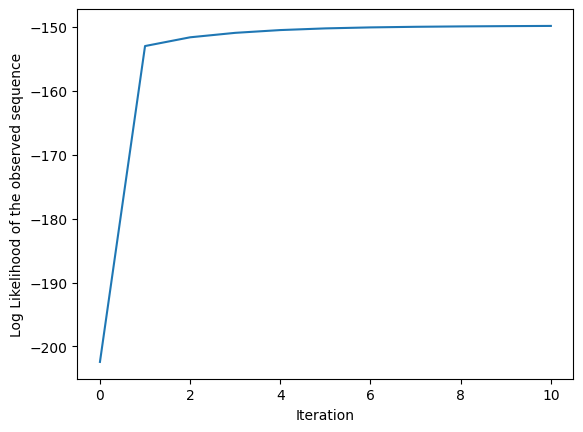

-149.85054538974057
Final Probabilities
[0. 1.]
[[0.891 0.109]
 [0.045 0.955]]
[[0.028 0.081 0.89 ]
 [0.381 0.36  0.26 ]]


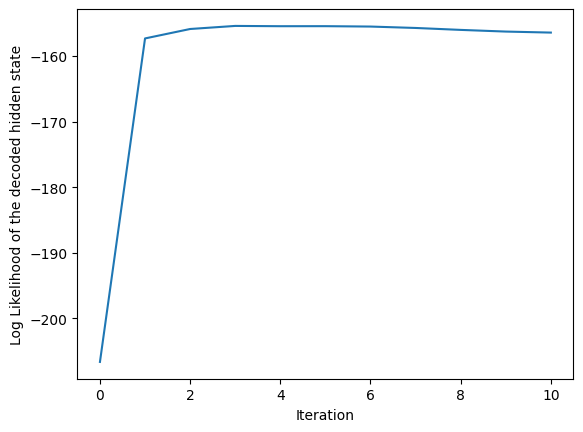

In [23]:
model = hmm.CategoricalHMM(
        n_components=2, random_state=19,
        init_params='')  # don't init transition, set it below
model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                            np.random.dirichlet([0.1, 0.9])])
model.startprob_=bT0
model.emissionprob_=bT1
score = model.score(X_validate)
print(score)
Lll=BWlib2(model.startprob_,model.transmat_,model.emissionprob_,X_train,11)

In [24]:
#Using CRN for the same problem

In [25]:
R=HMMCRN(['H1','H2'],['V1','V2','V3'])
R.Ob=X_train
Tr=R.EM(1)
RG=crnsimulator.ReactionGraph(Tr)

In [ ]:
%%time
filename,odename=RG.write_ODE_lib(filename='CasinoDetectorReaction.py')

In [26]:
n=2
m=3
l=len(X_train)
I=ran_init(n,m,X_train.T[0])
start=init_simulator(n,m,l,I,'CasinoDetectorReaction.py')

In [27]:
%%time
!python CasinoDetectorReaction.py --a 1e-3 --r 1e-3 --t8 0.05 --t-lin 100 --nxy>103.dat

CPU times: user 14.1 ms, sys: 11.1 ms, total: 25.2 ms
Wall time: 1.04 s


CRN initialization
Starting Prob:
 [0.83379125 0.16620875]
Transition:
 [[0.10430156 0.89569844]
 [0.01456763 0.98543237]]
Emission:
 [[0.12327319 0.07161    0.80511681]
 [0.07343782 0.88798297 0.03857922]]

CRN Equilibrium
Starting Prob:
 [0.803 0.197]
Transition:
 [[0.48  0.52 ]
 [0.435 0.565]]
Emission:
 [[0.282 0.23  0.488]
 [0.268 0.349 0.382]]


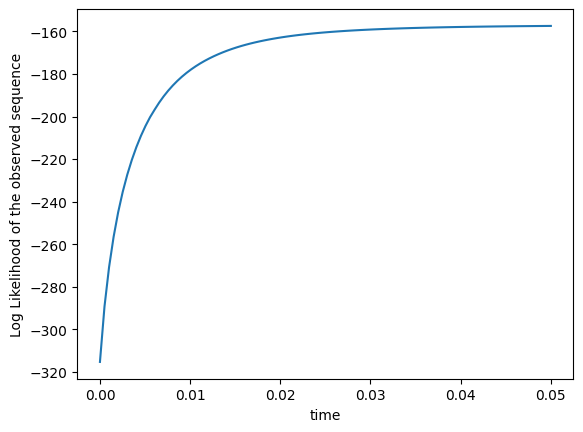

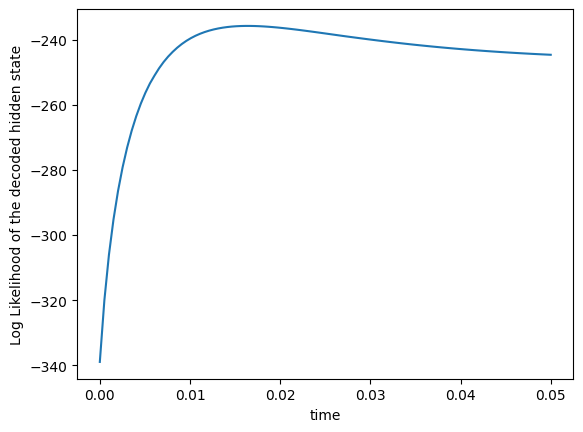

-157.43364221576772
CRN_Transition fit:
 [[0.481 0.519]
 [0.436 0.564]]
 
CRN_Emission fit:
 [[0.282 0.23  0.488]
 [0.269 0.349 0.383]]
[0.802 0.198]


In [28]:
Final=!tail -n 2 103.dat
Init=!head -n 2 103.dat
Y1=Init[0].split()[1:]
Y2=Final[0].split()[1:]
print_conc(start,Y1,Y2,n,m)
t1,c1L,c1T0,c1TT,c1T1=crn_Liklihood('103.dat',start,X_validate,n,m)
print(c1T0[-1].round(3))

[0.80227618 0.19772382]
[[0.4806222  0.5193778 ]
 [0.43567716 0.56432284]]
[[0.28203362 0.22977168 0.4881947 ]
 [0.26857804 0.3486597  0.38276226]]
-157.43364221576772


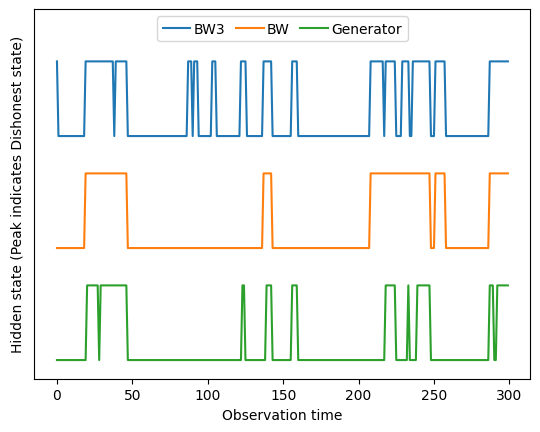

Start Generated:
[1 0]

Start Recovered:
[0.6 0.4]

CRN Start Recovered:
[0.802 0.198]


Transmission Matrix Generated:
[[0.95 0.05]
 [0.25 0.75]]

Transmission Matrix Recovered:
[[0.999 0.001]
 [0.007 0.993]]

CRN Transmission Matrix Recovered:
[[0.481 0.519]
 [0.436 0.564]]


Emission Matrix Generated:
[[0.333 0.333 0.333]
 [0.01  0.01  0.98 ]]

Emission Matrix Recovered:
[[0.088 0.688 0.223]
 [0.25  0.6   0.15 ]]

CRN Emission Matrix Recovered:
[[0.282 0.23  0.488]
 [0.269 0.349 0.383]]




In [61]:
crn_model = hmm.CategoricalHMM(
        n_components=2,
        init_params='')
crn_model.startprob_=c1T0[-1]
crn_model.transmat_=c1TT[-1]
crn_model.emissionprob_=c1T1[-1]

print(crn_model.startprob_)
print(crn_model.transmat_)
print(crn_model.emissionprob_)
score = crn_model.score(X_validate)
print(score)
crn_states = crn_model.predict(rolls)
fig, ax = plt.subplots()
ax.plot(1-crn_states[:500] + 3.0, label='BW3')
ax.plot(1-states[:500] + 1.5, label='BW')
ax.plot(gen_states[:500], label='Generator')
ax.set_yticks([])
ax.set_ylim(-0.25,4.7)
#ax.set_title('States compared to generated')
ax.set_ylabel('Hidden state (Peak indicates Dishonest state)')
ax.set_xlabel('Observation time')
ax.legend(ncol=3,loc='upper center',columnspacing=0.75,handletextpad=0.25)
plt.savefig('PLOTS/hidest.pdf', format='pdf', dpi=300)
plt.show()

print(f'Start Generated:\n{gen_model.startprob_.round(3)}\n\n'
      f'Start Recovered:\n{model.startprob_.round(3)}\n\n'
      f'CRN Start Recovered:\n{crn_model.startprob_.round(3)}\n\n')



print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{model.transmat_.round(3)}\n\n'
      f'CRN Transmission Matrix Recovered:\n{crn_model.transmat_.round(3)}\n\n')


print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{model.emissionprob_.round(3)}\n\n'
      f'CRN Emission Matrix Recovered:\n{crn_model.emissionprob_.round(3)}\n\n')
